In [1]:
# !pip install sklearn_pandas

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import sklearn
import sklearn.decomposition
from sklearn.model_selection import train_test_split
import sklearn.ensemble
import sklearn_pandas

%matplotlib inline

PATH = Path('../..').resolve()
seed = 12345

In [3]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv')

# PCA x Random Forest regression

See for inspiration: https://github.com/87surendra/Random-Forest-Image-Classification-using-Python/blob/master/Random-Forest-Image-Classification-using-Python.ipynb

## Load targets & pixels

In [4]:
y = df.logfgas.to_numpy()

In [5]:
# this takes up 1 GB of memory on disk... (~2 min)
# X = np.array([np.array(Image.open(f'{PATH}/images-OC/{o}.jpg')).flatten() for o in df.AGCNr])
# np.save(f'{PATH}/data/raveled_a40A_images.npy', X)

In [6]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')

## Compress using PCA

In [7]:
n_components = 16
batch_size = 200

In [8]:
pca = sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=batch_size)

In [9]:
# scales like O(bs * n^2) where n=150,000 is original num of pixels
# inverting these gigantic matrices is a pain... (~2 min)

pca.fit(X)
# X_pca = pca.transform(X)


IncrementalPCA(batch_size=200, copy=True, n_components=16, whiten=False)

In [10]:
# np.save(f'{PATH}/data/raveled_a40A_images-PCA.npy', X_pca)
X_pca = np.load(f'{PATH}/data/raveled_a40A_images-PCA.npy')

## Train RF

In [11]:
# hyperparams
num_trees = 100

validation_pct = 0.20

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=validation_pct, random_state=seed)

In [13]:
X_train.shape, y_train.shape

((5919, 16), (5919,))

In [14]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=num_trees, random_state=seed)

In [15]:
# this is somewhat slow....
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [16]:
p_test = rf.predict(X_test)

In [17]:
rmse = ((p_test - y_test)**2).mean()**0.5
rmse

0.31201420797427

In [27]:
slope = lambda y, p: ((y - y.mean())*(p - p.mean())).sum() / ((y - y.mean())**2).sum()

In [35]:
# sanity check
slope(np.arange(10), np.arange(10)), slope(np.arange(10), np.arange(10)[::-1])

(1.0, -1.0)

In [36]:
slope(y_test, p_test)

0.7054343874837188

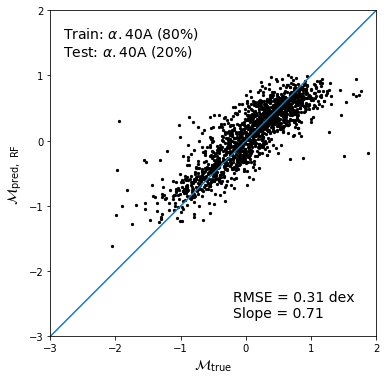

In [44]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-3, 2)
plt.ylim(-3, 2)

plt.text(-2.8, 1.3, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(-0.2, -2.7, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)
plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ RF}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/RF_a40_train-test.pdf')

# Use xGASS to validate RF trained on $\alpha.40$

In [19]:
xg = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')

X_xgass = np.array([np.array(Image.open(f'{PATH}/images-xGASS/{o}.jpg')).flatten() for o in xg.GASS])

In [20]:
# apply same PCA
X_xgass_pca = pca.transform(X_xgass)

In [21]:
y_xg = np.array(xg.lgGF)

In [22]:
p_xg = rf.predict(X_xgass_pca)

In [23]:
rmse = ((y_xg - p_xg)**2).mean()**0.5
rmse

0.7096269250137444

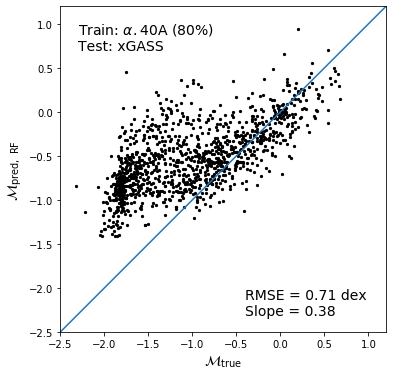

In [51]:
plt.figure(figsize=(6, 6))

plt.scatter(y_xg, p_xg, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 1.2)
plt.ylim(-2.5, 1.2)

plt.text(-2.3, 0.7, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: xGASS', fontsize=14)
plt.text(-0.4, -2.3, f'RMSE = {((p_xg - y_xg)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_xg, p_xg):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ RF}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/RF_a40_train-xGASS_test.pdf')

# Only xGASS Train/test (plus re-fit using custom PCA)

In [52]:
X_xgass_pca = pca.fit_transform(X_xgass)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_xgass_pca, y_xg, test_size=validation_pct, random_state=seed)

In [54]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [55]:
p_test = rf.predict(X_test)

In [56]:
rmse = ((y_test - p_test)**2).mean()**0.5
rmse

0.4069568300289398

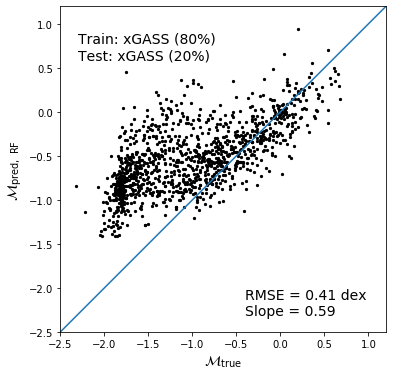

In [58]:
plt.figure(figsize=(6, 6))

plt.scatter(y_xg, p_xg, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 1.2)
plt.ylim(-2.5, 1.2)

plt.text(-2.3, 0.6, r'Train: xGASS (80%)' + '\n' +r'Test: xGASS (20%)', fontsize=14)
plt.text(-0.4, -2.3, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ RF}$', fontsize=14);


plt.savefig(f'{PATH}/results/simpler-models/RF_xGASS_train-test.pdf')

# Combined $\alpha.40$ and xGASS train/test

In [59]:
X.shape, X_xgass.shape

((7399, 150528), (1179, 150528))

In [60]:
X_combined = np.vstack([X, X_xgass])
X_combined.shape

(8578, 150528)

In [61]:
y_combined = np.hstack([y, y_xg])
y_combined.shape

(8578,)

In [62]:
X_combined_pca = pca.fit_transform(X_combined)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_pca, y_combined, test_size=validation_pct, random_state=seed)

In [64]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [65]:
p_test = rf.predict(X_test)

In [66]:
rmse = ((p_test - y_test)**2).mean()**0.5
rmse

0.3448389977812641

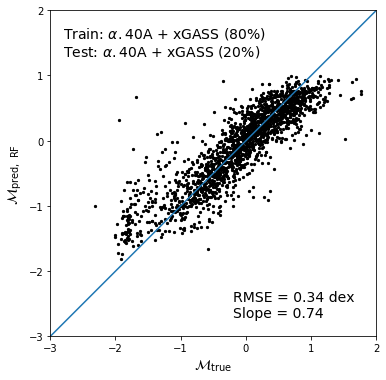

In [68]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-3, 2)
plt.ylim(-3, 2)

plt.text(-2.8, 1.3, r'Train: $\alpha.40$A + xGASS (80%)' + '\n' +r'Test: $\alpha.40$A + xGASS (20%)', fontsize=14)
plt.text(-0.2, -2.7, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ RF}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/RF_combined_train-test.pdf')